In [1]:
%matplotlib inline
from google.cloud import storage
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
import numpy as np
from pathlib import Path
import tensorflow as tf
import os

In [2]:
# Define bucket and blob prefix

label_bucket_name = 'catflap-photo-labels'
photo_bucket_name = 'catflap-photos-raw'

In [3]:
# Set up buckets

client = storage.Client()
label_bucket = client.get_bucket(label_bucket_name)
photo_bucket = client.get_bucket(photo_bucket_name)

In [4]:
# Define filepath

filepath = '/home/jupyter/labelled_dataset/'

# Construct ground truth data set from labels

In [5]:
# Get list of blob names

blobs = label_bucket.list_blobs()
blob_list = [blob.name for blob in blobs]
blob_list

['cat_detection_labels - 2020-05-11.csv',
 'cat_detection_labels - 2020-05-12.csv',
 'cat_detection_labels - 2020-05-13.csv',
 'cat_detection_labels - 2020-05-14.csv',
 'cat_detection_labels - 2020-05-15.csv',
 'cat_detection_labels - 2020-05-16.csv',
 'cat_detection_labels - 2020-05-17.csv']

In [6]:
# Read labels into pandas dataframe

df_list = []
for blob in blob_list:
    labels = pd.read_csv('gs://'+label_bucket_name+'/'+blob)
    df_list += [labels]
label_df = pd.concat(df_list, ignore_index=True, sort=False)

print(label_df.shape)
label_df.head()

(34142, 6)


,blob_location,contains_cat,in_or_out,entering_or_exiting,seen_through,proportion_of_cat
0,gs://catflap-photos-raw/2020-05-11_080042.jpg,False,NaN,NaN,NaN,NaN
1,gs://catflap-photos-raw/2020-05-11_080050.jpg,False,NaN,NaN,NaN,NaN
2,gs://catflap-photos-raw/2020-05-11_080058.jpg,False,NaN,NaN,NaN,NaN
3,gs://catflap-photos-raw/2020-05-11_080105.jpg,False,NaN,NaN,NaN,NaN
4,gs://catflap-photos-raw/2020-05-11_080112.jpg,False,NaN,NaN,NaN,NaN


In [7]:
# Get positive examples

positive_examples = label_df[label_df.contains_cat]
positive_examples = positive_examples[positive_examples.in_or_out == 'in']
positive_examples = positive_examples[positive_examples.proportion_of_cat>.8]

print(positive_examples.shape)
positive_examples.head()

(32, 6)


,blob_location,contains_cat,in_or_out,entering_or_exiting,seen_through,proportion_of_cat
98,gs://catflap-photos-raw/2020-05-11_081307.jpg,True,in,NaN,NaN,1.0
99,gs://catflap-photos-raw/2020-05-11_081314.jpg,True,in,NaN,NaN,1.0
100,gs://catflap-photos-raw/2020-05-11_081325.jpg,True,in,NaN,NaN,1.0
101,gs://catflap-photos-raw/2020-05-11_081332.jpg,True,in,NaN,NaN,1.0
247,gs://catflap-photos-raw/2020-05-11_083124.jpg,True,in,entering,NaN,1.0


In [8]:
# Get negative examples

negative_to_positive_ratio = 10
number_negative_exampels = negative_to_positive_ratio * len(positive_examples)
negative_examples = label_df[label_df.contains_cat == False].sample(n = number_negative_exampels)

print(negative_examples.shape)
negative_examples.head()

(320, 6)


,blob_location,contains_cat,in_or_out,entering_or_exiting,seen_through,proportion_of_cat
26326,gs://catflap-photos-raw/2020-05-15_173820.jpg,False,NaN,NaN,NaN,NaN
19053,gs://catflap-photos-raw/2020-05-14_125123.jpg,False,NaN,NaN,NaN,NaN
3539,gs://catflap-photos-raw/2020-05-11_160032.jpg,False,NaN,NaN,NaN,NaN
29903,gs://catflap-photos-raw/2020-05-16_142859.jpg,False,NaN,NaN,NaN,NaN
13577,gs://catflap-photos-raw/2020-05-13_131724.jpg,False,NaN,NaN,NaN,NaN


In [9]:
# Concatenate positive and negative examples

labelled_blobs = pd.concat([positive_examples, negative_examples], ignore_index=True)
labelled_blobs = labelled_blobs[['blob_location','contains_cat']]

print(labelled_blobs.shape)
labelled_blobs.head()

(352, 2)


,blob_location,contains_cat
0,gs://catflap-photos-raw/2020-05-11_081307.jpg,True
1,gs://catflap-photos-raw/2020-05-11_081314.jpg,True
2,gs://catflap-photos-raw/2020-05-11_081325.jpg,True
3,gs://catflap-photos-raw/2020-05-11_081332.jpg,True
4,gs://catflap-photos-raw/2020-05-11_083124.jpg,True


In [10]:
# Check all blob_locations are unique

assert labelled_blobs.blob_location.nunique() == len(labelled_blobs)

In [11]:
# Check we have the right ratio of positive and negative examples

assert labelled_blobs.contains_cat.sum() * negative_to_positive_ratio == (labelled_blobs.contains_cat==False).sum()

In [12]:
# Extract filename

labelled_blobs['filename'] = labelled_blobs.blob_location.str.split('/').apply(lambda x: x[-1])

labelled_blobs.head()

,blob_location,contains_cat,filename
0,gs://catflap-photos-raw/2020-05-11_081307.jpg,True,2020-05-11_081307.jpg
1,gs://catflap-photos-raw/2020-05-11_081314.jpg,True,2020-05-11_081314.jpg
2,gs://catflap-photos-raw/2020-05-11_081325.jpg,True,2020-05-11_081325.jpg
3,gs://catflap-photos-raw/2020-05-11_081332.jpg,True,2020-05-11_081332.jpg
4,gs://catflap-photos-raw/2020-05-11_083124.jpg,True,2020-05-11_083124.jpg


# Download images to disk from Cloud Storage

In [13]:
# Download images

download_images = False

if download_images:
    for filename in labelled_blobs.filename:

        blob = photo_bucket.blob(filename)
        blob_str = blob.download_to_filename(filepath+filename)

# Read data set from disk

In [14]:
# Read files from disk

filenames = []
dataset = []
for filename in os.listdir(filepath):
    if 'jpg' in filename:
        img = mpimg.imread(filepath+filename)

        filenames += [filename]
        dataset += [img[:,:,0]] # single colour

In [15]:
# Add labels to files loaded from disk

labels_from_disk = pd.DataFrame()
labels_from_disk['filename'] = filenames
labels_from_disk['contains_cat'] = False
labels_from_disk.loc[labels_from_disk[labels_from_disk.filename.isin(labelled_blobs[labelled_blobs.contains_cat].filename)].index,'contains_cat'] = True

print(labels_from_disk.shape)
labels_from_disk.head()

(352, 2)


,filename,contains_cat
0,2020-05-15_120616.jpg,False
1,2020-05-11_192639.jpg,False
2,2020-05-12_081531.jpg,False
3,2020-05-14_105241.jpg,False
4,2020-05-12_090435.jpg,False


# Create train, validation and test sets

In [16]:
# Split

labels_from_disk['fold'] = 'train'
labels_from_disk.loc[labels_from_disk.sample(frac=.3).index, 'fold'] = 'test'
labels_from_disk.loc[labels_from_disk[labels_from_disk.fold=='train'].sample(frac=.5).index, 'fold'] = 'valid'

labels_from_disk.head()

,filename,contains_cat,fold
0,2020-05-15_120616.jpg,False,valid
1,2020-05-11_192639.jpg,False,train
2,2020-05-12_081531.jpg,False,valid
3,2020-05-14_105241.jpg,False,train
4,2020-05-12_090435.jpg,False,valid


In [17]:
# Convert contains cat from boolean to integer

labels_from_disk['contains_cat_int'] = labels_from_disk.contains_cat.astype('int32')
labels_from_disk.head()

,filename,contains_cat,fold,contains_cat_int
0,2020-05-15_120616.jpg,False,valid,0
1,2020-05-11_192639.jpg,False,train,0
2,2020-05-12_081531.jpg,False,valid,0
3,2020-05-14_105241.jpg,False,train,0
4,2020-05-12_090435.jpg,False,valid,0


In [18]:
# Count each fold

labels_from_disk.groupby(['fold','contains_cat']).filename.count().unstack()

contains_cat,False,True
fold,,
test,95,11
train,114,9
valid,111,12


In [19]:
# Create train, test and validation data frames

train_labels = labels_from_disk[labels_from_disk.fold=='train']
valid_labels = labels_from_disk[labels_from_disk.fold=='valid']
test_labels = labels_from_disk[labels_from_disk.fold=='test']

print(train_labels.shape)
print(valid_labels.shape)
print(test_labels.shape)

(123, 4)
(123, 4)
(106, 4)


In [20]:
# Create dataset variables

train_dataset = np.array([dataset[i] for i in train_labels.index]).astype('float32')
valid_dataset = np.array([dataset[i] for i in valid_labels.index]).astype('float32')
test_dataset = np.array([dataset[i] for i in test_labels.index]).astype('float32')

In [21]:
# Create constants

downsample_by = 10

image_height = int(600 / downsample_by)
image_width = int(800 / downsample_by)
n_colours = 1
n_labels = 2

In [22]:
# Downsample pixels

train_dataset = train_dataset[:,::downsample_by,::downsample_by]
test_dataset = test_dataset[:,::downsample_by,::downsample_by]
valid_dataset = valid_dataset[:,::downsample_by,::downsample_by]

# Construct model

In [23]:
# Build model

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(image_height, image_width)),
    tf.keras.layers.Dense(2)
])

In [25]:
# Define loss function

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [26]:
# Compile model

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [27]:
# Train model

model_fit = model.fit(train_dataset, train_labels.contains_cat_int, epochs=100, verbose=0)

In [28]:
# Make predictions and insert into validation data set

valid_labels.loc[:,'prediction'] = np.argmax(model.predict(valid_dataset), axis=-1)

valid_labels.head()

/home/jupyter/.local/share/virtualenvs/cat-detection-DpT3z93U/lib/python3.5/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/jupyter/.local/share/virtualenvs/cat-detection-DpT3z93U/lib/python3.5/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,filename,contains_cat,fold,contains_cat_int,prediction
0,2020-05-15_120616.jpg,False,valid,0,0
2,2020-05-12_081531.jpg,False,valid,0,0
4,2020-05-12_090435.jpg,False,valid,0,0
16,2020-05-11_084446.jpg,False,valid,0,0
19,2020-05-13_084635.jpg,False,valid,0,0


# Analyse predictions for validation data set

In [29]:
# Calculate confusion matrix

valid_labels.groupby(['contains_cat_int','prediction']).filename.count().unstack()

prediction,0,1
contains_cat_int,,
0,111.0,NaN
1,3.0,9.0


In [30]:
# Create columns for each cell in confusion matrix

valid_labels.loc[:,'tp'] = (valid_labels.contains_cat_int==1) & (valid_labels.prediction==1)
valid_labels.loc[:,'fp'] = (valid_labels.contains_cat_int==0) & (valid_labels.prediction==1)
valid_labels.loc[:,'fn'] = (valid_labels.contains_cat_int==1) & (valid_labels.prediction==0)
valid_labels.loc[:,'tn'] = (valid_labels.contains_cat_int==0) & (valid_labels.prediction==0)

valid_labels.head()

,filename,contains_cat,fold,contains_cat_int,prediction,tp,fp,fn,tn
0,2020-05-15_120616.jpg,False,valid,0,0,False,False,False,True
2,2020-05-12_081531.jpg,False,valid,0,0,False,False,False,True
4,2020-05-12_090435.jpg,False,valid,0,0,False,False,False,True
16,2020-05-11_084446.jpg,False,valid,0,0,False,False,False,True
19,2020-05-13_084635.jpg,False,valid,0,0,False,False,False,True


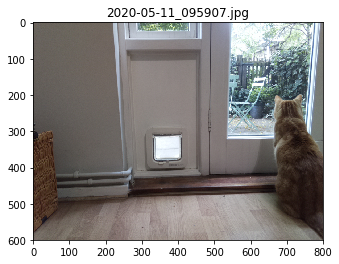

In [31]:
# Plot trainint set containing Thomas

for blob_name in train_labels[train_labels.contains_cat].filename:
    
    blob = photo_bucket.blob(blob_name)
    blob_str = blob.download_as_string()
    bytes_io = io.BytesIO(blob_str)
    img = mpimg.imread(bytes_io, format='jpg')
    plt.figure()
    plt.imshow(img)
    plt.title(blob_name)
    
    break

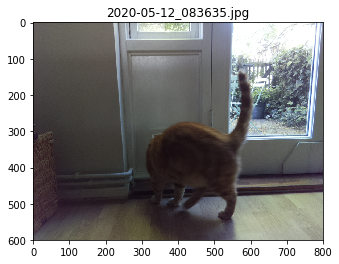

In [32]:
# Plot true positives

for blob_name in valid_labels[valid_labels.tp].filename:
    
    blob = photo_bucket.blob(blob_name)
    blob_str = blob.download_as_string()
    bytes_io = io.BytesIO(blob_str)
    img = mpimg.imread(bytes_io, format='jpg')
    plt.figure()
    plt.imshow(img)
    plt.title(blob_name)
    
    break

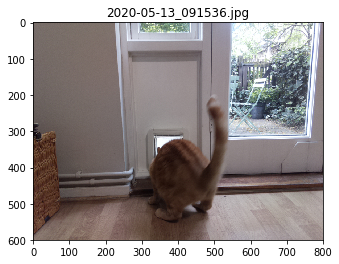

In [33]:
# Plot false negatives

for blob_name in valid_labels[valid_labels.fn].filename:
    
    blob = photo_bucket.blob(blob_name)
    blob_str = blob.download_as_string()
    bytes_io = io.BytesIO(blob_str)
    img = mpimg.imread(bytes_io, format='jpg')
    plt.figure()
    plt.imshow(img)
    plt.title(blob_name)
    
    break